# Figure 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import torch

sys.path.insert(0, '../')

from src.dataset import get_num_classes, load_dataset
from src.models import init_model

In [3]:
architecture = 'cnn-large'
dataset_names = ['celeba-old', 'celeba']
num_classes = 2

datasets = []
for dataset_name in dataset_names:
    dataset = load_dataset(dataset=dataset_name, 
                           transform='resize_normalize', 
                           dataset_size=0, 
                           seed=42,
                           path='../data')
    datasets.append(dataset['train_and_test'])

Young count:  156734 Old count:  45865
Size of celeba-old: 45865
Young count:  156734 Old count:  45865
Size of celeba: 202599


Label 0


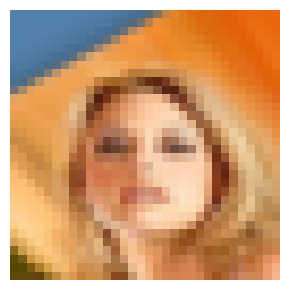

In [4]:
tidx = 23
target_record, label = datasets[1][tidx]
print('Label', label)

def imshow(img):
    plt.subplots(figsize=(3, 3))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.tight_layout()
    plt.savefig('plots/person.pdf')
    plt.show()
    plt.close()

imshow(target_record)

In [5]:
@torch.no_grad()
def get_activation_maps(model, image, layer=1):
    C, D1, D2 = image.size()
    output1 = model.conv1(image.view(1, C, D1, D2))
    if layer == 1:
        return output1.squeeze(0)
    elif layer == 2:
        output2 = model.conv2(output1).view(50, 5, 5)
        return output2
    else:
        raise ValueError(f'ERROR: Invalid layer {layer}.')

In [6]:
print('Loading the models')
models = dict({dataset_name: [] for dataset_name in dataset_names})
num_experiments = [2, 5]
for di, dataset_name in enumerate(models):
    experiments_dir = f'../experiments/{dataset_name}/controlled_randomness/cnn-large/dsize-20000'
    models_dir = os.path.join(experiments_dir, 'dataset_disjoint')
    for exp in range(num_experiments[di]):
        models_path = os.path.join(models_dir, f'exp_{exp}_model.pickle')
        if not os.path.exists(models_path):
            continue
        with open(models_path, 'rb') as f:
            saved_model = pickle.load(f)
        model = init_model(architecture, num_classes, verbose=False)
        model.load_state_dict(saved_model['model_state_dict'])
        model.eval()
        models[dataset_name].append(model)
    print(f'Found {len(models[dataset_name])} models for the {dataset_name} experiment.')

Loading the models
Found 2 models for the celeba-old experiment.
Found 5 models for the celeba experiment.


# Visualisation of shadow models trained under different distributions

_Note:_ It takes a few seconds to generate the visualisation.

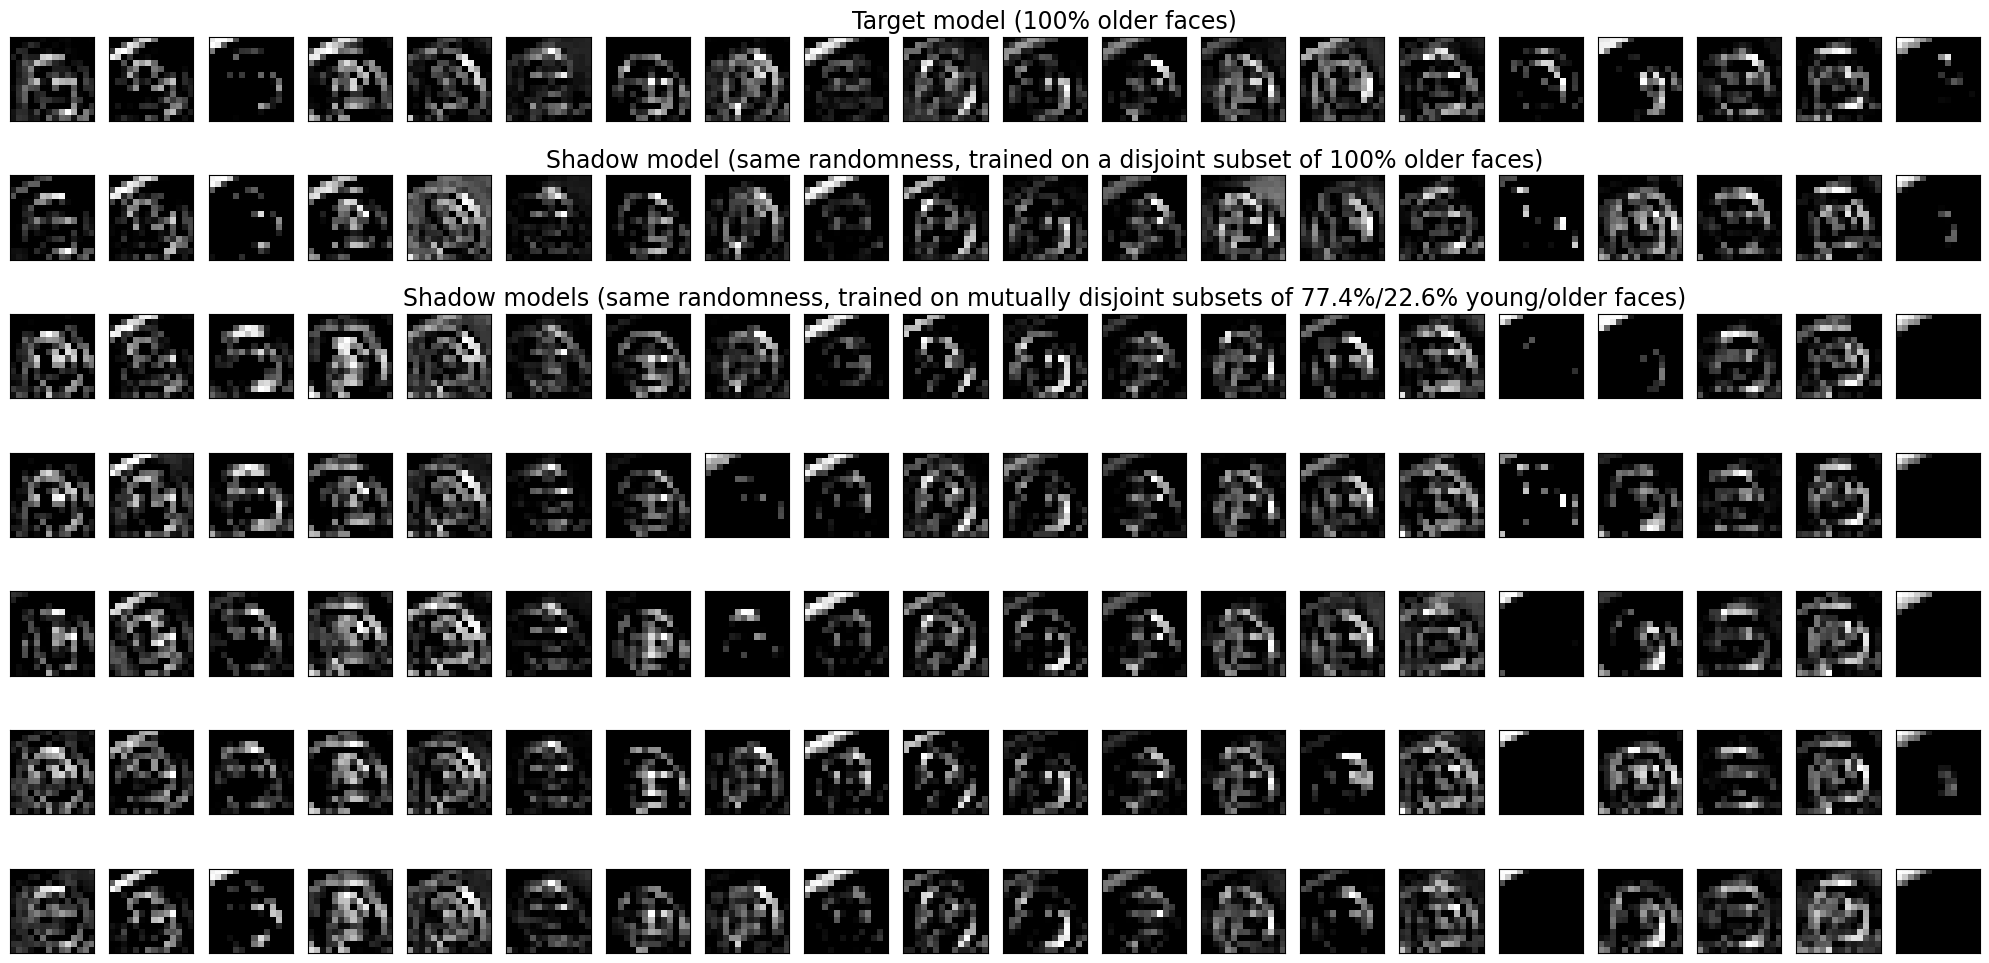

In [7]:
layer = 1

fig, axes = plt.subplots(num_experiments[0]+num_experiments[1], 20, figsize=(20, 10))

idx = 0
for di, dataset_name in enumerate(models):
    for exp in range(num_experiments[di]):
        maps = get_activation_maps(models[dataset_name][exp], target_record, layer=layer)
        layer_viz = maps.data
        for i, filter in enumerate(layer_viz):
            if i == layer_viz.size(0): 
                break
            axes[idx][i].imshow((filter-filter.min())/(filter.max()-filter.min()), vmin=0, vmax=1, cmap='gray')
            axes[idx][i].imshow((filter-filter.min())/(filter.max()-filter.min()), vmin=0, vmax=1, cmap='gray')
            axes[idx][i].tick_params(
                axis='both',
                which='both',# both major and minor ticks are affected
                bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        idx += 1

axes[0][10].set_title('Target model (100% older faces)', fontsize=17)
axes[1][10].set_title('Shadow model (same randomness, trained on a disjoint subset of 100% older faces)', fontsize=17)
axes[2][10].set_title('Shadow models (same randomness, trained on mutually disjoint subsets of 77.4%/22.6% young/older faces)', fontsize=17)


plt.tight_layout()
plt.savefig(f'plots/different_distribution_dataset_disjoint.pdf', bbox_inches='tight')
plt.show()
plt.close()